In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec
import itertools
import operator
import numpy as np
import math
%matplotlib inline 
plt.ion()
#plt.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

from time import time
import datetime

import sys
sys.path.append('../simulations/')
from grid_manager import *
from habitat_analysis import *
from hdf5_reader import *

In [2]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb

blues = make_colormap(
    [c('white'), c('steelblue')])
yellows = make_colormap(
    [c('black'), c('gold')])
greens = make_colormap(
    [c('white'), c('green')])
greys = make_colormap(
    [c('white'), c('black')])

#N = 1000
#colors = np.random.uniform(-2, 2, size=(N,))
#plt.scatter(array_dg[:, 0], array_dg[:, 1], c=colors, cmap=blues)

## Landscape simulation function:

In [3]:
def perm_wall_sim(grid_shape = (30,60), Q=1, A=0.5, ww=3, wp=0.5, cw=[3,3], cp=[0.35,0.7], ia=0.):
    # 1. initialize landscape
    n_rows,n_cols = grid_shape
    N = n_rows*n_cols
    if type(Q) is not str:
        qualities = np.ones((N,))*Q
        g = Grid(shape=grid_shape, qualities=qualities)
    else:
        g = Grid(shape=grid_shape)
    g.A = A * g.A
 
    # 2. compute the wall
    wpt = int(math.floor(n_cols*wp)-math.ceil(ww/2))
    xs = range(wpt, wpt+ww)
     
    # 3. compute the corridors
    for i in range(len(cw)):
        cpt=int(math.floor(n_rows*cp[i])-math.ceil(cw[i]/2))
        if i == 0:
            ys = range(cpt)
        else:
            ys=ys+range(max(ys)+1+cw[i-1], cpt)
    ys=ys+range(max(ys)+1+cw[i], n_rows)
     
    impossible_nodes = list(itertools.product(ys,xs))
    g.set_impossible_nodes(impossible_nodes, impossible_affinity=ia)

    if type(Q) is str:
        if Q is "in_degree":
            g.qualities = np.sum(g.A, axis=0).A.flatten()
        if Q is "out_degree":
            g.qualities = np.sum(g.A, axis=1).A.flatten()
    elif ia > 0:
        for i in impossible_nodes:
            ids = g.grid_coordinates_to_node_id(i)
            g.qualities[ids] = 0.0 
    return g


In [4]:
def perm_wall_sim_3_corridors(grid_shape = (30,60), Q=1, A=0.5, ww=3, wp=0.5, cw=[3,3], cp=[0.35,0.7], ia=0.):
    # 1. initialize landscape
    n_rows,n_cols = grid_shape
    N = n_rows*n_cols
    if type(Q) is not str:
        qualities = np.ones((N,))*Q
        g = Grid(shape=grid_shape, qualities=qualities)
    else:
        g = Grid(shape=grid_shape)
    g.A = A * g.A
 
    # 2. compute the wall
    wpt = int(math.floor(n_cols*wp)-math.ceil(ww/2))
    xs = range(wpt, wpt+ww)
     
    # 3. compute the corridors
    
    ys = [x for x in range(n_rows) if x not in [0, n_rows-1, np.floor(n_rows/2)]]
     
    impossible_nodes = list(itertools.product(ys,xs))
    g.set_impossible_nodes(impossible_nodes, impossible_affinity=ia)

    if type(Q) is str:
        if Q is "in_degree":
            g.qualities = np.sum(g.A, axis=0).A.flatten()
        if Q is "out_degree":
            g.qualities = np.sum(g.A, axis=1).A.flatten()
    elif ia > 0:
        for i in impossible_nodes:
            ids = g.grid_coordinates_to_node_id(i)
            g.qualities[ids] = 0.0 
    return g


# check the extreme examples


In [5]:
#affinity = 1.
affinity = 0.35
ia = 0. # IMPOSSIBLE AFFINITY
Q = 1.

lgs = []
lgs.append(perm_wall_sim(grid_shape = (31,61), Q=Q, A=affinity, ww=5, wp=0.5, cw=[5,0], cp=[0.5,0.7], ia=ia))
lgs.append(perm_wall_sim(grid_shape = (31,61), Q=Q, A=affinity, ww=5, wp=0.5, cw=[7,0], cp=[0.5,0.7], ia=ia))
# lgs.append(perm_wall_sim(grid_shape = [30,60], Q=Q, A=affinity, ww=5, wp=0.5, cw=[7,0], cp=[0.5,0.7])[0])
# lgs.append(perm_wall_sim(grid_shape = (31,61), Q=Q, A=affinity, ww=5, wp=0.5, cw=[0,0], cp=[0.5,0.7], ia=ia))


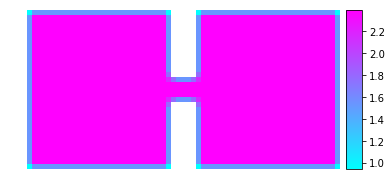

In [6]:
lgs[0].plot_indegrees()

In [7]:
betas = [10., 1., 0.1, 1e-2, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
# betas = [1, 1e-5, 0.]


## First, compute HFs and mean KLDs for corridor width 3:

In [8]:
lg_i = 0

distances = {}
all_HFs = {}
res = np.zeros((len(lgs),len(betas)))

distances[lg_i] = {}
all_HFs[lg_i] = {}

G = lgs[lg_i]
mean_D_KLs = np.zeros((len(betas)))
for j in range(len(betas)):
    print "Beta " + str(j+1) + "/" + str(len(betas))
    RSP = HabitatAnalysis(G, \
                          beta = betas[j], \
                          similarity_measure='RSP_dissimilarity', \
                          affinity_to_cost='paper_choice', \
                          distance_to_similarity='paper_choice', \
                          verbose=False)
    RSP.compute_similarities()
    
    D_KL = RSP.compute_KL_divergences_to()
    mean_D_KLs[j] = np.mean(D_KL[D_KL>0])
    
    #
    # SAVE DISTANCE MATRIX FROM EACH RUN:
    #
    distances[lg_i][j] = RSP.distances_all2L.copy()
    HFs = RSP.compute_habitat_functionalities_from_similarities()
    all_HFs[lg_i][j] = HFs

    # HFs2 = HFs*RSP.G.qualities
    LF = np.dot(HFs,RSP.G.qualities)
    res[lg_i,j] = LF

Beta 1/11
Beta 2/11
Beta 3/11
Beta 4/11
Beta 5/11
Beta 6/11
Beta 7/11
Beta 8/11
Beta 9/11
Beta 10/11
Beta 11/11


## Plot of mean KL-divergence w.r.t. theta:

### The computation for KL-divergence of the least cost path distribution is not yet implemented. We can see that with theta=10, KLD doesn't yet seem to converge to any steady value...

/anaconda3/envs/py2env/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


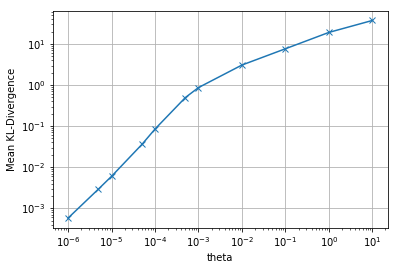

In [9]:
plt.loglog(betas, mean_D_KLs, '-x')
#plt.axhline(mean_D_KLs[0], '--', label="KL-D with LC")
plt.xlabel("theta")
plt.ylabel("Mean KL-Divergence")
plt.grid('on')

## Then, compute HFs for corridor width 5:

In [10]:
lg_i = 1

G = lgs[lg_i]
distances[lg_i] = {}
all_HFs[lg_i] = {}

for j in range(len(betas)):
    print "Beta " + str(j+1) + "/" + str(len(betas))
    RSP = HabitatAnalysis(G, \
                          beta = betas[j], \
                          similarity_measure='RSP_dissimilarity', \
                          affinity_to_cost='paper_choice', \
                          distance_to_similarity='paper_choice', \
                          verbose=False)
    RSP.compute_similarities()
    
    D_KL = RSP.compute_KL_divergences_to()
    # mean_D_KLs[lg_i,j] = np.mean(D_KL[D_KL>0])
    
    #
    # SAVE DISTANCE MATRIX FROM EACH RUN:
    #
    distances[lg_i][j] = RSP.distances_all2L.copy()
    HFs = RSP.compute_habitat_functionalities_from_similarities()
    all_HFs[lg_i][j] = HFs

    # HFs2 = HFs*RSP.G.qualities
    LF = np.dot(HFs,RSP.G.qualities)
    res[lg_i,j] = LF

Beta 1/11
Beta 2/11
Beta 3/11
Beta 4/11
Beta 5/11
Beta 6/11
Beta 7/11
Beta 8/11
Beta 9/11
Beta 10/11
Beta 11/11


## Plot change in LF w.r.t. $\theta$:

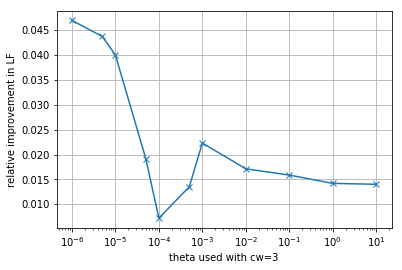

In [11]:
rel_improvement = ((res[1,:] - res[0,:])/res[0,:]).T
plt.semilogx(betas, rel_improvement, 'x-')
plt.xlabel('theta used with cw=3')
plt.ylabel('relative improvement in LF')
plt.grid('on')


## Compute new values of $\theta$ corresponding to same mean KL-div as in the first landscape:

In [12]:
from scipy.optimize import fsolve

def find_beta_with_mean_D_KL(beta, *data):
    beta = beta[0]
    G = data[0]
    old_mean_D_KL = data[1]
    
    landscape = HabitatAnalysis(G, \
        beta = beta, \
        similarity_measure='RSP_dissimilarity', \
        affinity_to_cost='paper_choice', \
        distance_to_similarity='paper_choice', \
        verbose=False)
    try:
        landscape.compute_similarities()
    except ValueError:
        return 99
            
    D_KL = landscape.compute_KL_divergences_to()
    mean_D_KL = np.mean(D_KL[D_KL>0])
    return mean_D_KL-old_mean_D_KL

In [13]:
G = lgs[1]

new_betas = np.zeros((len(betas)))
for j in range(len(betas)):
    init_beta = betas[j]
    old_mean_D_KL = mean_D_KLs[j]
    new_beta = fsolve(find_beta_with_mean_D_KL, init_beta, args=(G, old_mean_D_KL))[0]
    print str(init_beta) + " --> " + str(new_beta)
    new_betas[j] = new_beta

10.0 --> 10.623105072580962
1.0 --> 1.0356897888327383
0.1 --> 0.10449533524747674
0.01 --> 0.010791835779645492
0.001 --> 0.001080292368227567
0.0005 --> 0.0005414119760523604
0.0001 --> 0.00010915535639708335
5e-05 --> 5.298252296415883e-05
1e-05 --> 1.0047121503022864e-05
5e-06 --> 4.989347328525544e-06
1e-06 --> 9.929041393183011e-07


## Compute LFs with new $\theta$s:

In [15]:
lg_i = 1

G = lgs[lg_i]
distances[lg_i] = {}
all_HFs[lg_i] = {}

for j in range(len(betas)):
    beta = new_betas[j]
    print "Beta " + str(j+1) + "/" + str(len(betas)) + " = " + str(beta)
    RSP = HabitatAnalysis(G,\
                    beta = beta, \
                    similarity_measure='RSP_dissimilarity', \
                    affinity_to_cost='paper_choice', \
                    distance_to_similarity='paper_choice', \
                    verbose=False)
    RSP.compute_similarities()
        
    #
    # SAVE DISTANCE MATRIX FROM EACH RUN:
    #
    distances[lg_i][j] = RSP.distances_all2L.copy()
    HFs = RSP.compute_habitat_functionalities_from_similarities()
    all_HFs[lg_i][j] = HFs

    # HFs2 = HFs*RSP.G.qualities
    LF = np.dot(HFs,RSP.G.qualities)
    res[lg_i,j] = LF

Beta 1/11 = 10.623105072580962
Beta 2/11 = 1.0356897888327383
Beta 3/11 = 0.10449533524747674
Beta 4/11 = 0.010791835779645492
Beta 5/11 = 0.001080292368227567
Beta 6/11 = 0.0005414119760523604
Beta 7/11 = 0.00010915535639708335
Beta 8/11 = 5.298252296415883e-05
Beta 9/11 = 1.0047121503022864e-05
Beta 10/11 = 4.989347328525544e-06
Beta 11/11 = 9.929041393183011e-07


## Plot change in LF w.r.t. $\theta$:

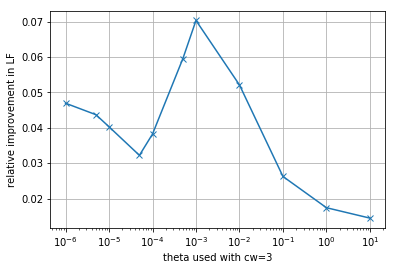

In [16]:
rel_improvement = ((res[1,:] - res[0,:])/res[0,:]).T
plt.semilogx(betas, rel_improvement, 'x-')
plt.xlabel('theta used with cw=3')
plt.ylabel('relative improvement in LF')
plt.grid('on')
